In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

In [2]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.training.trainer import Trainer

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [3]:
train_dataset = ToyData(num_signals=1684, signal_length=256)
validation_dataset = ToyData(num_signals=round(1684 * 0.1), signal_length=256)

### Dataset Plots

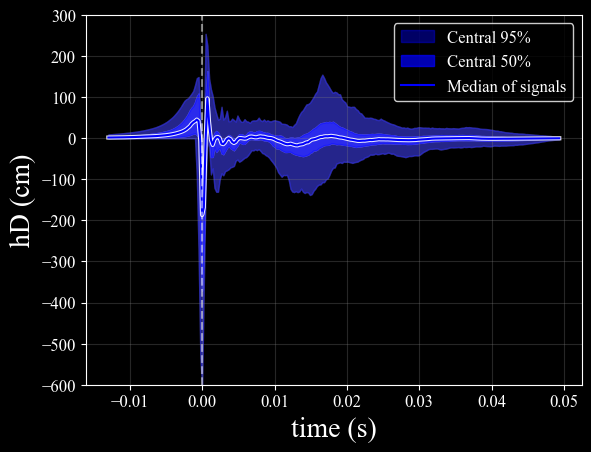

In [ ]:
ccsn_dataset = CCSNData()
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir")

In [5]:
toy=False

### Train VAE + Flow

In [ ]:
vae_trainer = Trainer(toy=toy)
vae_trainer.train()

Epochs:   1%|          | 1/128 [00:00<02:03,  1.02it/s]

Epoch 1/128 | Train Loss: 143.9138 | Val Loss: 112.4200


Epochs:   2%|▏         | 2/128 [00:01<01:38,  1.28it/s]

Epoch 2/128 | Train Loss: 96.0996 | Val Loss: 86.0096


Epochs:   2%|▏         | 3/128 [00:02<01:28,  1.41it/s]

Epoch 3/128 | Train Loss: 75.4843 | Val Loss: 67.3707


Epochs:   3%|▎         | 4/128 [00:02<01:26,  1.44it/s]

Epoch 4/128 | Train Loss: 64.9066 | Val Loss: 61.3722


Epochs:   4%|▍         | 5/128 [00:03<01:27,  1.41it/s]

Epoch 5/128 | Train Loss: 59.9656 | Val Loss: 56.7727


Epochs:   5%|▍         | 6/128 [00:04<01:23,  1.45it/s]

Epoch 6/128 | Train Loss: 55.9286 | Val Loss: 52.8552


Epochs:   5%|▌         | 7/128 [00:04<01:21,  1.48it/s]

Epoch 7/128 | Train Loss: 52.6077 | Val Loss: 50.0021


Epochs:   6%|▋         | 8/128 [00:05<01:23,  1.44it/s]

Epoch 8/128 | Train Loss: 48.4003 | Val Loss: 46.8188


Epochs:   7%|▋         | 9/128 [00:06<01:21,  1.46it/s]

Epoch 9/128 | Train Loss: 46.8883 | Val Loss: 45.4103


Epochs:   8%|▊         | 10/128 [00:06<01:19,  1.49it/s]

Epoch 10/128 | Train Loss: 44.7400 | Val Loss: 43.6532


Epochs:   9%|▊         | 11/128 [00:07<01:18,  1.50it/s]

Epoch 11/128 | Train Loss: 43.2159 | Val Loss: 43.5197


Epochs:   9%|▉         | 12/128 [00:08<01:16,  1.51it/s]

Epoch 12/128 | Train Loss: 43.0024 | Val Loss: 42.0527


### Display Results

In [ ]:
vae_trainer.display_results()